In [57]:
%matplotlib notebook

In [58]:
import ROOT
from ROOT import TFile, TTree, TCanvas, TH2D, TH1F
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants

In [59]:
f = TFile("selectedEventsTrueRecoBoth_withTrueTrkDir_withParticleEs_110424.root","READ") # have particle energies, AND corrected so everything is in GeV
#f = TFile("selectedEventsTrueRecoBoth_withTrueTrkDir_110424.root","READ") # has truth px/py/pz etc
#f = TFile("selectedEventsTrueRecoBoth_withTrkDir_wuthTrackComp_102824.root","READ") # with track completeness score
#f = TFile("selectedEventsTrueRecoBoth_withTrkDir_102824.root","READ") 

t = f.Get("selectedEvents")

entries = t.GetEntries()
print(entries)

10913


In [60]:
t.GetEntry(5)

def getTransverseAxis(eNu, pxMu, pyMu, pzMu):
    pV = np.array([0, 0, eNu])
    pMu = np.array([pxMu, pyMu, pzMu])
    z = np.cross(pV, pMu)
    magZ = np.sqrt( z[0]**2 + z[1]**2 + z[2]**2 )
    #return z / magZ
    return z / np.linalg.norm(z) # same as my magZ eqn above

print(t.recoSel_recoNuE_)
print(t.recoSel_trkDirMuX_)
print(t.recoSel_trkDirMuY_)
print(t.recoSel_trkDirMuZ_)

z = getTransverseAxis(t.recoSel_recoNuE_,t.recoSel_trkDirMuX_,t.recoSel_trkDirMuY_,t.recoSel_trkDirMuZ_)

print("z: ", z )

0.48742047119140625
0.20603574812412262
-0.5030539631843567
0.839336633682251
z:  [ 0.92539155  0.3790125  -0.        ]


In [61]:
t.GetEntry(5)

pPi = np.array([t.recoSel_trkDirPiX_, t.recoSel_trkDirPiY_, t.recoSel_trkDirPiZ_])
pP = np.array([t.recoSel_trkDirPX_, t.recoSel_trkDirPY_, t.recoSel_trkDirPZ_])
print(pPi)
print(pP)

# 1st TKI observable, double-transverse momentum imbalance
def delPTT(z, pPi, pP): 
    pPiTT = np.dot(z,pPi)
    pPTT = np.dot(z,pP)
    return pPiTT + pPTT

print( delPTT(z, pPi, pP) )

[-0.93139738 -0.35108182 -0.09612767]
[-0.49275708  0.00754978  0.87013417]
-1.4481034428056607


In [62]:
t.GetEntry(5)

# sum of transverse momenta of the 3 particles
def delPT(pxPi, pxP, pxMu, pyPi, pyP, pyMu): 
    pTMu = np.array([pxMu, pyMu, 0])
    pTP = np.array([pxP, pyP, 0])
    pTPi = np.array([pxPi, pyPi, 0])
    return pTMu + pTPi + pTP

delPT_test = delPT(t.recoSel_trkDirPiX_, t.recoSel_trkDirPX_, t.recoSel_trkDirMuX_, t.recoSel_trkDirPiY_, t.recoSel_trkDirPY_, t.recoSel_trkDirMuY_)
print(delPT_test)

[-1.21811871 -0.846586    0.        ]


In [71]:
epsilon = 0.0309

# longitudinal component, the long way
def pL(pzP, pzMu, pzPi, eP, eMu, ePi, delPT): 
    mP = constants.physical_constants['proton mass energy equivalent in MeV'][0]/1000 
    print("mP: ", mP)
    mN = constants.physical_constants['neutron mass energy equivalent in MeV'][0]/1000
    print("mN: ", mN)
    B = 0.34381
    mA = 22*mN + 18*mP - B
    mA1 = mA - mN + epsilon
    del2 = np.dot(delPT, delPT)
    #pLP = np.array([0, 0, pzP])
    #pLMu = np.array([0, 0, pzMu])
    #pLPi = np.array([0, 0, pzPi])
    parens = mA + pzMu + pzPi + pzP - eMu - ePi - eP
    return 0.5*(parens) - 0.5*((del2+mA1**2)/(parens))

pL_test = pL(t.recoSel_trkDirPZ_, t.recoSel_trkDirMuZ_, t.recoSel_trkDirPiZ_, t.recoSel_eP_, t.recoSel_eMu_, t.recoSel_ePi_, delPT_test)
#print(t.pzP_)
print("pL_test: ", pL_test)

def pLGKI(pzP, pzMu, pzPi, eP, eMu, ePi):
    pRest = constants.physical_constants['proton mass energy equivalent in MeV'][0]/1000
    piRest = 139.57/1000 # GeV
    print("piRest:", piRest)
    #Ecal = eMu + (eP-pRest) + (ePi-piRest) + epsilon
    Ecal = eMu + (eP-pRest) + ePi + epsilon
    return pzMu + pzP + pzPi - Ecal

pLGKI_test = pLGKI(t.recoSel_trkDirPZ_, t.recoSel_trkDirMuZ_, t.recoSel_trkDirPiZ_, t.recoSel_eP_, t.recoSel_eMu_, t.recoSel_ePi_)
print("pLGKI_test: ", pLGKI_test)

mP:  0.93827208816
mN:  0.93956542052
pL_test:  -1478.1704556181317
piRest: 0.13957
pLGKI_test:  -2993.09562791184


In [63]:
# 3rd TKI observable, boosting angle
def delAlphaT(pxMu, pyMu, delPT): 
    pTMu = np.array([pxMu, pyMu, 0])
    magPTMu = np.sqrt( pTMu[0]**2 + pTMu[1]**2 + pTMu[2]**2 )
    magDelPT = np.sqrt( delPT[0]**2 + delPT[1]**2 + delPT[2]**2 )
    dot = np.dot(-pTMu,delPT)
    return np.arccos(dot / (magPTMu * magDelPT))

delAlphaT_test = delAlphaT(t.recoSel_trkDirMuX_, t.recoSel_trkDirMuY_, delPT_test)
print(delAlphaT_test)

1.7894261494069825


In [75]:
reco_delPTT_list = []
reco_delAlphaT_list = []

truth_delPTT_list = []
truth_delAlphaT_list = []

reco_weights_list = []
truth_weights_list = []

entries = t.GetEntries()

# main loop
for e in range(entries):

    t.GetEntry(e)
    
    if (t.passedSel_ == 2) or (t.passedSel_ == 3): # passes reco selection
        
        pPi = np.array([t.recoSel_trkDirPiX_, t.recoSel_trkDirPiY_, t.recoSel_trkDirPiZ_])
        pP = np.array([t.recoSel_trkDirPX_, t.recoSel_trkDirPY_, t.recoSel_trkDirPZ_])
    
        z = getTransverseAxis(t.recoSel_recoNuE_,t.recoSel_trkDirMuX_,t.recoSel_trkDirMuY_,t.recoSel_trkDirMuZ_)
        delPT_entry = delPT(t.recoSel_trkDirPiX_, t.recoSel_trkDirPX_, t.recoSel_trkDirMuX_, t.recoSel_trkDirPiY_, t.recoSel_trkDirPY_, t.recoSel_trkDirMuY_)
    
        reco_delPTT_list.append( delPTT(z, pPi, pP) )
        reco_delAlphaT_list.append( delAlphaT(t.recoSel_trkDirMuX_, t.recoSel_trkDirMuY_, delPT_entry) )
        
        reco_weights_list.append(t.weight_)
        
    if (t.passedSel_ == 1) or (t.passedSel_ == 3): # passes truth selection
        
        pPi = np.array([t.truthSel_pxPi_, t.truthSel_pyPi_, t.truthSel_pzPi_])
        pP = np.array([t.truthSel_pxP_, t.truthSel_pyP_, t.truthSel_pzP_])
    
        z = getTransverseAxis(t.truthSel_eNu_,t.truthSel_pxMu_,t.truthSel_pyMu_,t.truthSel_pzMu_)
        delPT_entry = delPT(t.truthSel_pxPi_, t.truthSel_pxP_, t.truthSel_pxMu_, t.truthSel_pyPi_, t.truthSel_pyP_, t.truthSel_pyMu_)
    
        truth_delPTT_list.append( delPTT(z, pPi, pP) )
        truth_delAlphaT_list.append( delAlphaT(t.truthSel_pxMu_, t.truthSel_pyMu_, delPT_entry) )
        
        truth_weights_list.append(t.weight_)

reco_delPTT_arr = np.asarray(reco_delPTT_list)
reco_delAlphaT_arr = np.asarray(reco_delAlphaT_list)
reco_weights_arr = np.asarray(reco_weights_list)

truth_delPTT_arr = np.asarray(truth_delPTT_list)
truth_delAlphaT_arr = np.asarray(truth_delAlphaT_list)
truth_weights_arr = np.asarray(truth_weights_list)


print(reco_delPTT_arr)
print(reco_delAlphaT_arr)
print(reco_weights_arr)

print(truth_delPTT_arr)
print(truth_delAlphaT_arr)
print(truth_weights_arr)

[-0.1364364   0.42801682 -1.44810344 ... -0.30125282  1.5278701
 -0.53943322]
[2.7997534  2.71337491 1.78942615 ... 2.81071971 1.85419902 2.61555867]
[1. 1. 1. ... 1. 1. 1.]
[-0.22386779  0.00272604  0.15338779 ... -0.03408822 -0.35478951
 -0.00570452]
[2.2665348  1.43828787 2.63592588 ... 2.44930941 1.38212801 3.07223151]
[1. 1. 1. ... 1. 1. 1.]


In [65]:
# POT scaling for events that passed reco only

targetPOT = 1.3e21
sumPOT = 4.68e20 # this is for run 1
#sumPOT = 8.98e20 # this is for run 3

scale = targetPOT / sumPOT
print("Scale is: ", scale)

#print(np.sum(weights_arr))
#totalEvents = np.sum(weights_arr)*scale
#print("totalEvents: ", totalEvents)

Scale is:  2.7777777777777777


<IPython.core.display.Javascript object>


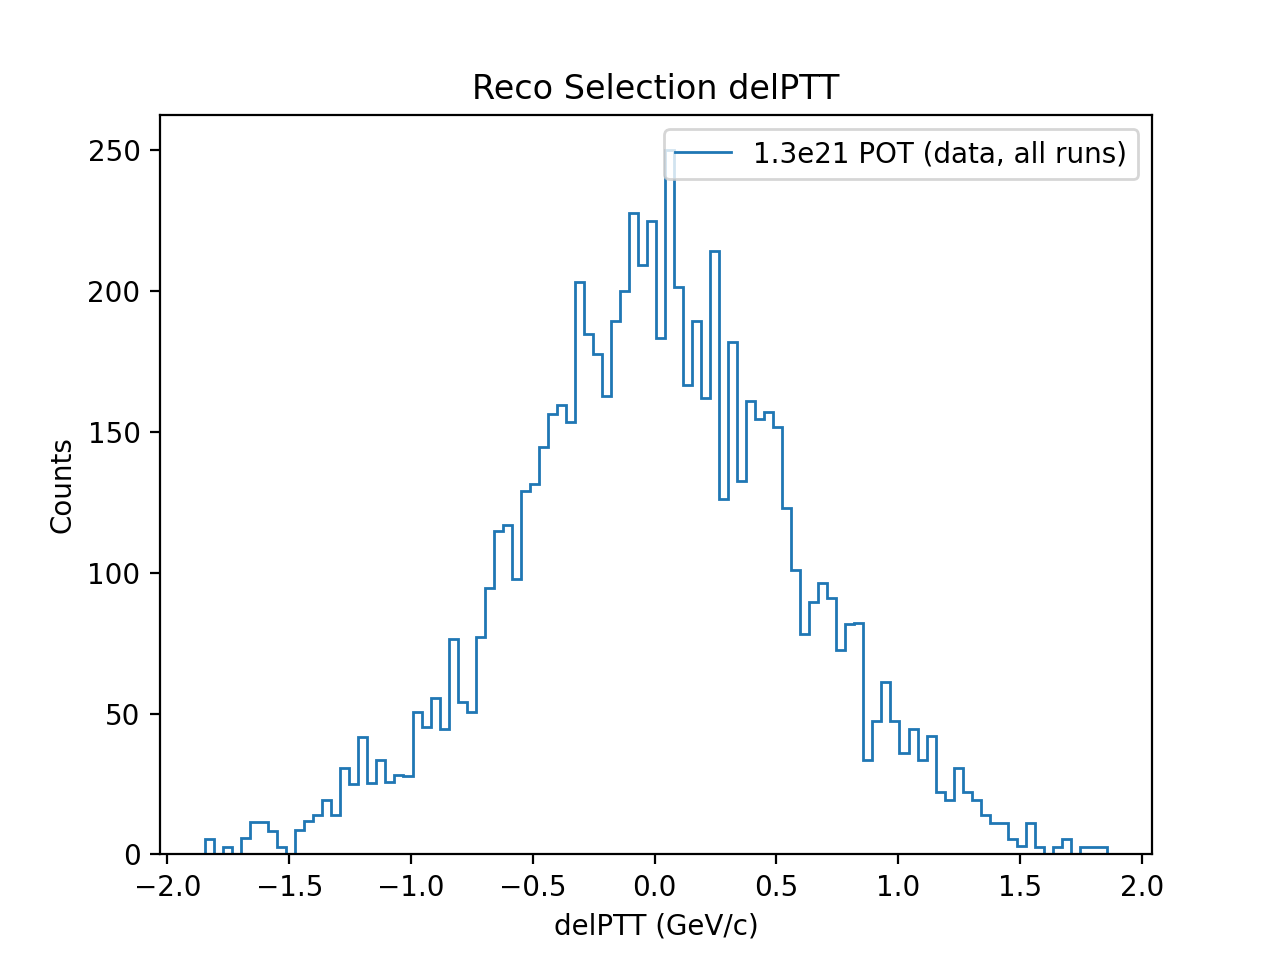

In [66]:
# delPTT reco plot

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(reco_delPTT_arr, bins=100, weights=reco_weights_arr)
scaledCounts = counts*scale


plt.stairs(scaledCounts, bins, label="1.3e21 POT (data, all runs)")
#plt.stairs(counts, bins, label="4.68e20 POT (sim, Run 1)")

plt.xlabel('delPTT (GeV/c)')
plt.ylabel('Counts')
plt.title('Reco Selection delPTT')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

<IPython.core.display.Javascript object>


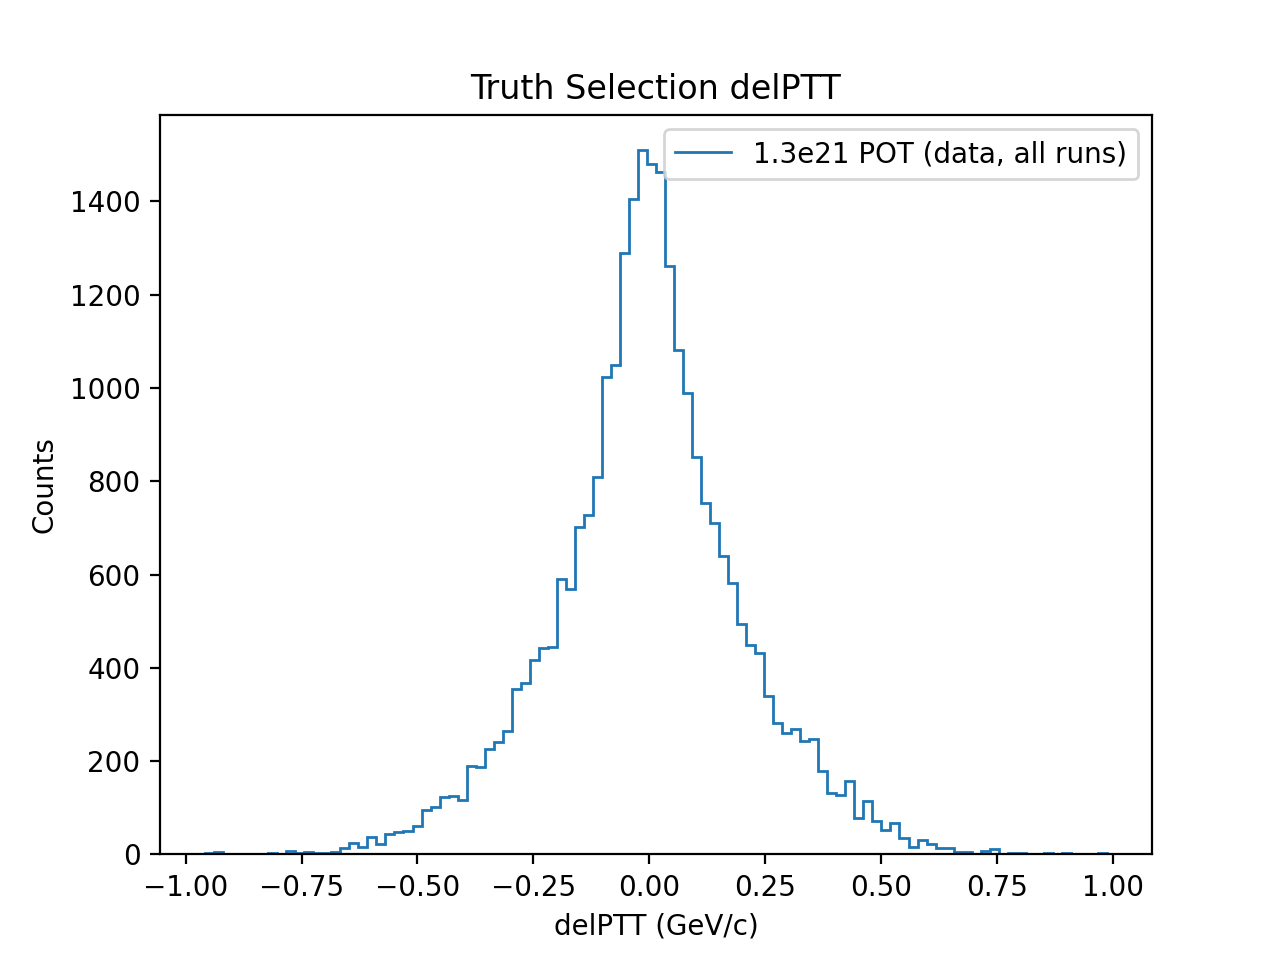

In [67]:
# delPTT truth plot

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(truth_delPTT_arr, bins=100, weights=truth_weights_arr)
scaledCounts = counts*scale


plt.stairs(scaledCounts, bins, label="1.3e21 POT (data, all runs)")
#plt.stairs(counts, bins, label="4.68e20 POT (sim, Run 1)")

plt.xlabel('delPTT (GeV/c)')
plt.ylabel('Counts')
plt.title('Truth Selection delPTT')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

<IPython.core.display.Javascript object>


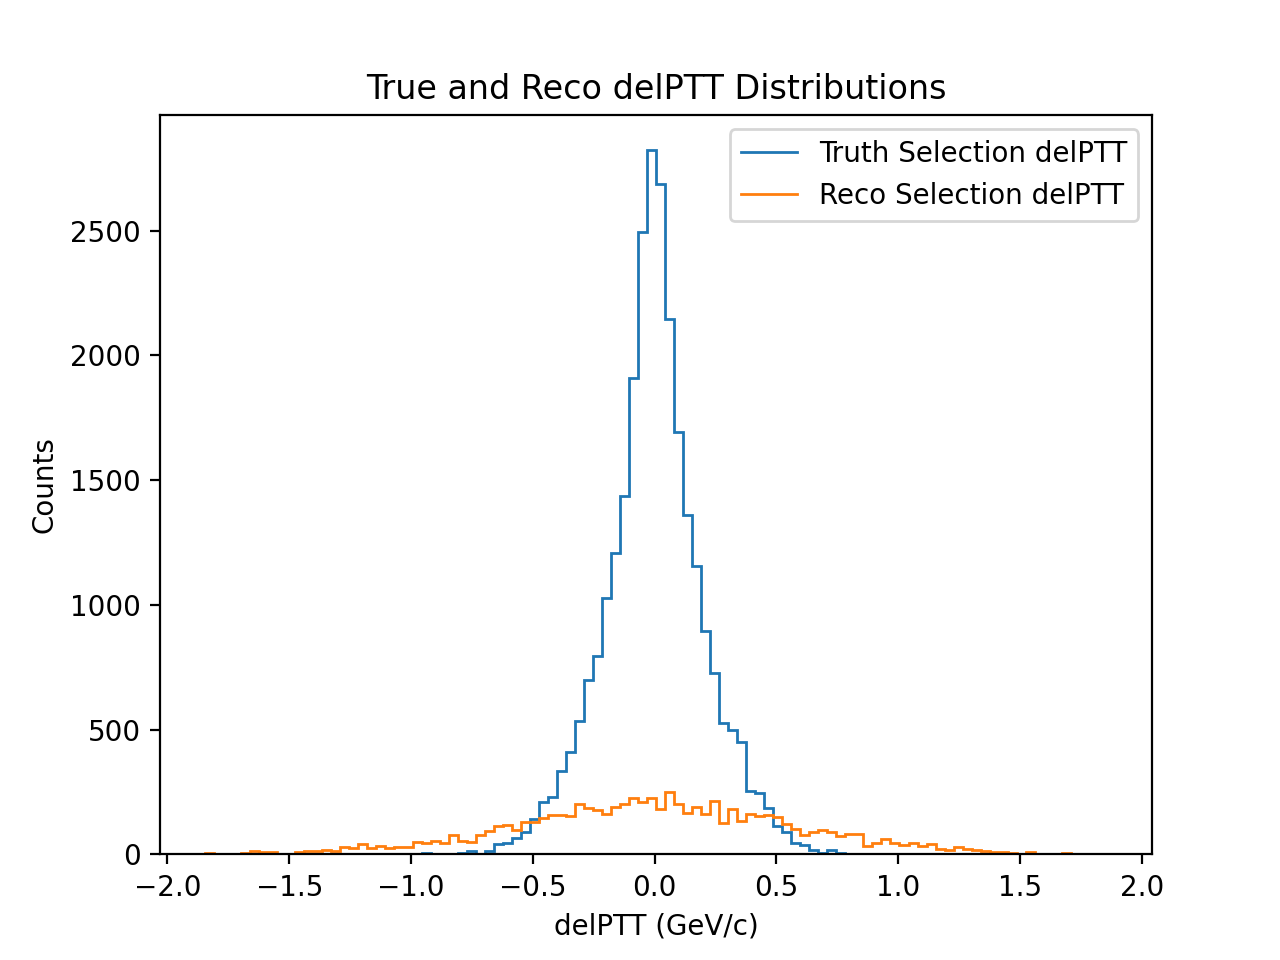

max value of truth:  0.9874523079886299
max value of reco:  1.8574071564417753
maxRange:  1.8574071564417753
truth bins:  [-1.84555008 -1.80852051 -1.77149094 -1.73446136 -1.69743179 -1.66040222
 -1.62337265 -1.58634307 -1.5493135  -1.51228393 -1.47525436 -1.43822478
 -1.40119521 -1.36416564 -1.32713607 -1.29010649 -1.25307692 -1.21604735
 -1.17901778 -1.14198821 -1.10495863 -1.06792906 -1.03089949 -0.99386992
 -0.95684034 -0.91981077 -0.8827812  -0.84575163 -0.80872205 -0.77169248
 -0.73466291 -0.69763334 -0.66060376 -0.62357419 -0.58654462 -0.54951505
 -0.51248547 -0.4754559  -0.43842633 -0.40139676 -0.36436719 -0.32733761
 -0.29030804 -0.25327847 -0.2162489  -0.17921932 -0.14218975 -0.10516018
 -0.06813061 -0.03110103  0.00592854  0.04295811  0.07998768  0.11701726
  0.15404683  0.1910764   0.22810597  0.26513554  0.30216512  0.33919469
  0.37622426  0.41325383  0.45028341  0.48731298  0.52434255  0.56137212
  0.5984017   0.63543127  0.67246084  0.70949041  0.74651999  0.78354956
  

In [68]:
# delPTT truth and reco plot for comparison (distributions)

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

# Creating bins (should be same for truth and reco if plotted together)
numberBins = 100

maxTruth = np.max(truth_delPTT_arr)
maxReco = np.max(reco_delPTT_arr)
maxRange = maxReco if maxReco > maxTruth else maxTruth

minTruth = np.min(truth_delPTT_arr)
minReco = np.min(reco_delPTT_arr)
minRange = minReco if minReco < minTruth else minTruth

binEdgeRange = (minRange, maxRange)

print("max value of truth: ", maxTruth)
print("max value of reco: ", maxReco)
print("maxRange: ", maxRange)

countsTrue, binsTrue = np.histogram(truth_delPTT_arr, bins=numberBins, weights=truth_weights_arr, range=binEdgeRange)
scaledCountsTrue = countsTrue*scale

print("truth bins: ", binsTrue)

print(sum(countsTrue))
print(sum(scaledCountsTrue))

countsReco, binsReco = np.histogram(reco_delPTT_arr, bins=numberBins, weights=reco_weights_arr, range=binEdgeRange)
scaledCountsReco = countsReco*scale

print("reco bins: ", binsReco)

print(sum(countsReco))
print(sum(scaledCountsReco))

plt.stairs(scaledCountsTrue, binsTrue, label="Truth Selection delPTT")
plt.stairs(scaledCountsReco, binsReco, label="Reco Selection delPTT")

plt.xlabel('delPTT (GeV/c)')
plt.ylabel('Counts')
plt.title('True and Reco delPTT Distributions')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

<IPython.core.display.Javascript object>


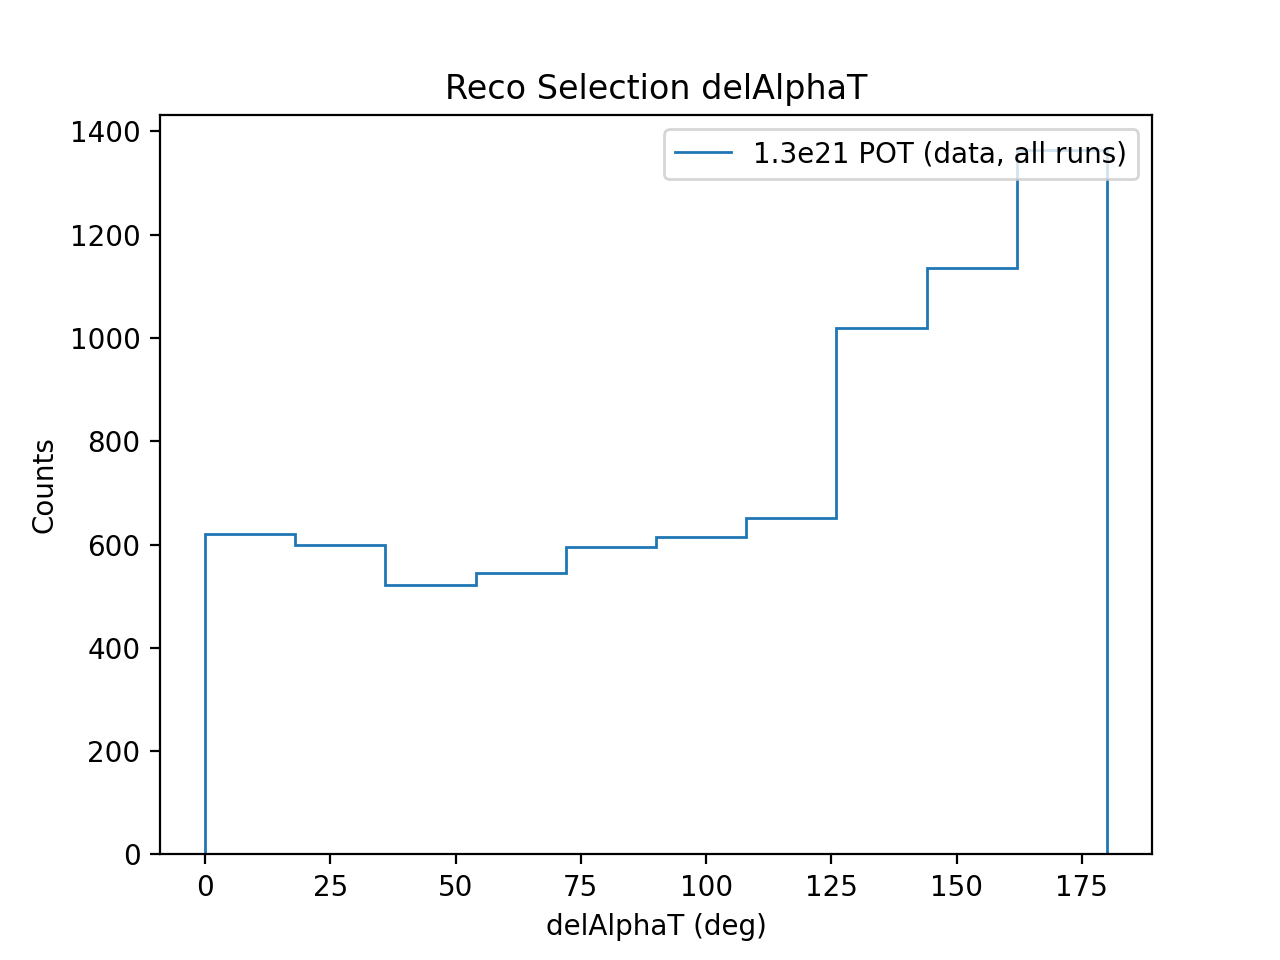

In [77]:
# delAlphaT reco plot

reco_delAlphaT_deg = reco_delAlphaT_arr*(180/np.pi)

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(reco_delAlphaT_deg, bins=10, weights=reco_weights_arr)
scaledCounts = counts*scale

plt.stairs(scaledCounts, bins, label="1.3e21 POT (data, all runs)")

plt.xlabel('delAlphaT (deg)')
plt.ylabel('Counts')
plt.title('Reco Selection delAlphaT')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

<IPython.core.display.Javascript object>


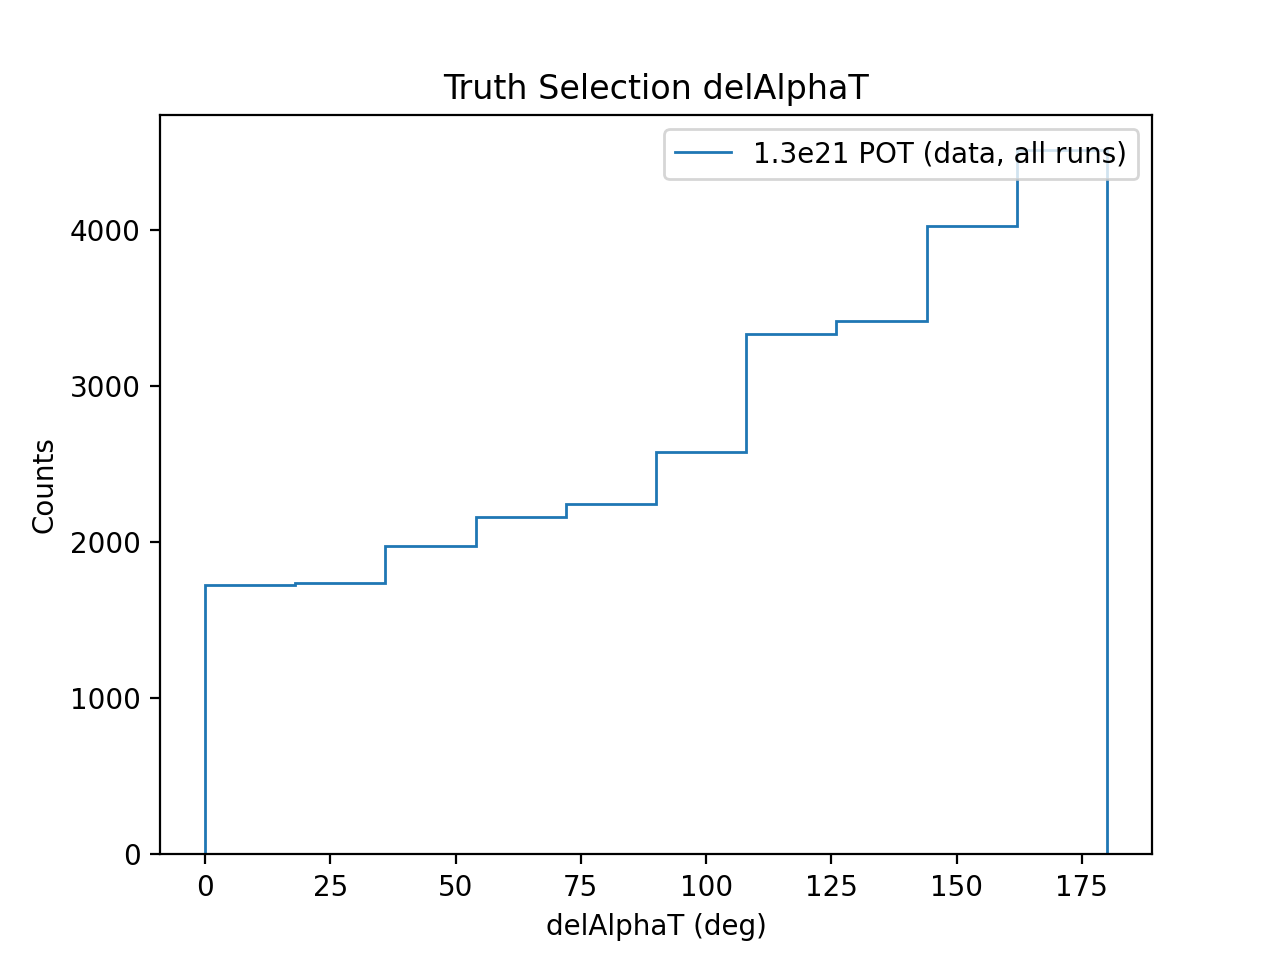

In [78]:
# delAlphaT truth plot

truth_delAlphaT_deg = truth_delAlphaT_arr*(180/np.pi)

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(truth_delAlphaT_deg, bins=10, weights=truth_weights_arr)
scaledCounts = counts*scale

plt.stairs(scaledCounts, bins, label="1.3e21 POT (data, all runs)")

plt.xlabel('delAlphaT (deg)')
plt.ylabel('Counts')
plt.title('Truth Selection delAlphaT')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

<IPython.core.display.Javascript object>


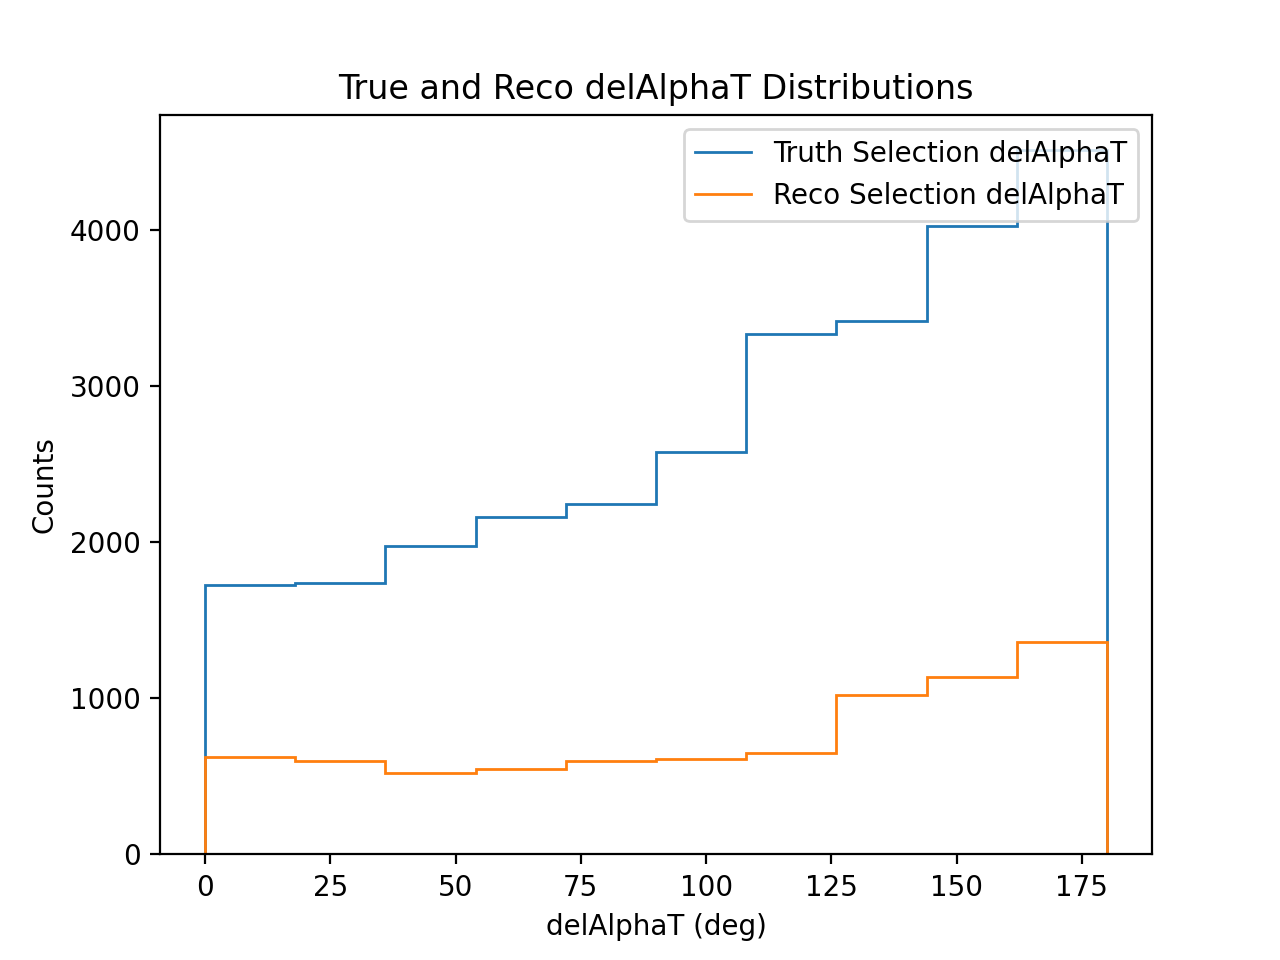

max value of truth:  179.9926016826059
max value of reco:  179.99812787801793
maxRange:  179.99812787801793
truth bins:  [2.86699936e-03 1.80023931e+01 3.60019192e+01 5.40014453e+01
 7.20009714e+01 9.00004974e+01 1.08000024e+02 1.25999550e+02
 1.43999076e+02 1.61998602e+02 1.79998128e+02]
9977.248706321414
27714.579739781704
reco bins:  [2.86699936e-03 1.80023931e+01 3.60019192e+01 5.40014453e+01
 7.20009714e+01 9.00004974e+01 1.08000024e+02 1.25999550e+02
 1.43999076e+02 1.61998602e+02 1.79998128e+02]
2759.6499766424636
7665.694379562399


In [79]:
# delAlphaT truth and reco plot for comparison (distributions)

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

reco_delAlphaT_deg = reco_delAlphaT_arr*(180/np.pi)
truth_delAlphaT_deg = truth_delAlphaT_arr*(180/np.pi)

# Creating bins (should be same for truth and reco if plotted together)
numberBins = 10

maxTruth = np.max(truth_delAlphaT_deg)
maxReco = np.max(reco_delAlphaT_deg)
maxRange = maxReco if maxReco > maxTruth else maxTruth

minTruth = np.min(truth_delAlphaT_deg)
minReco = np.min(reco_delAlphaT_deg)
minRange = minReco if minReco < minTruth else minTruth

binEdgeRange = (minRange, maxRange)

print("max value of truth: ", maxTruth)
print("max value of reco: ", maxReco)
print("maxRange: ", maxRange)

countsTrue, binsTrue = np.histogram(truth_delAlphaT_deg, bins=numberBins, weights=truth_weights_arr, range=binEdgeRange)
scaledCountsTrue = countsTrue*scale

print("truth bins: ", binsTrue)

print(sum(countsTrue))
print(sum(scaledCountsTrue))

countsReco, binsReco = np.histogram(reco_delAlphaT_deg, bins=numberBins, weights=reco_weights_arr, range=binEdgeRange)
scaledCountsReco = countsReco*scale

print("reco bins: ", binsReco)

print(sum(countsReco))
print(sum(scaledCountsReco))

plt.stairs(scaledCountsTrue, binsTrue, label="Truth Selection delAlphaT")
plt.stairs(scaledCountsReco, binsReco, label="Reco Selection delAlphaT")

plt.xlabel('delAlphaT (deg)')
plt.ylabel('Counts')
plt.title('True and Reco delAlphaT Distributions')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

<IPython.core.display.Javascript object>


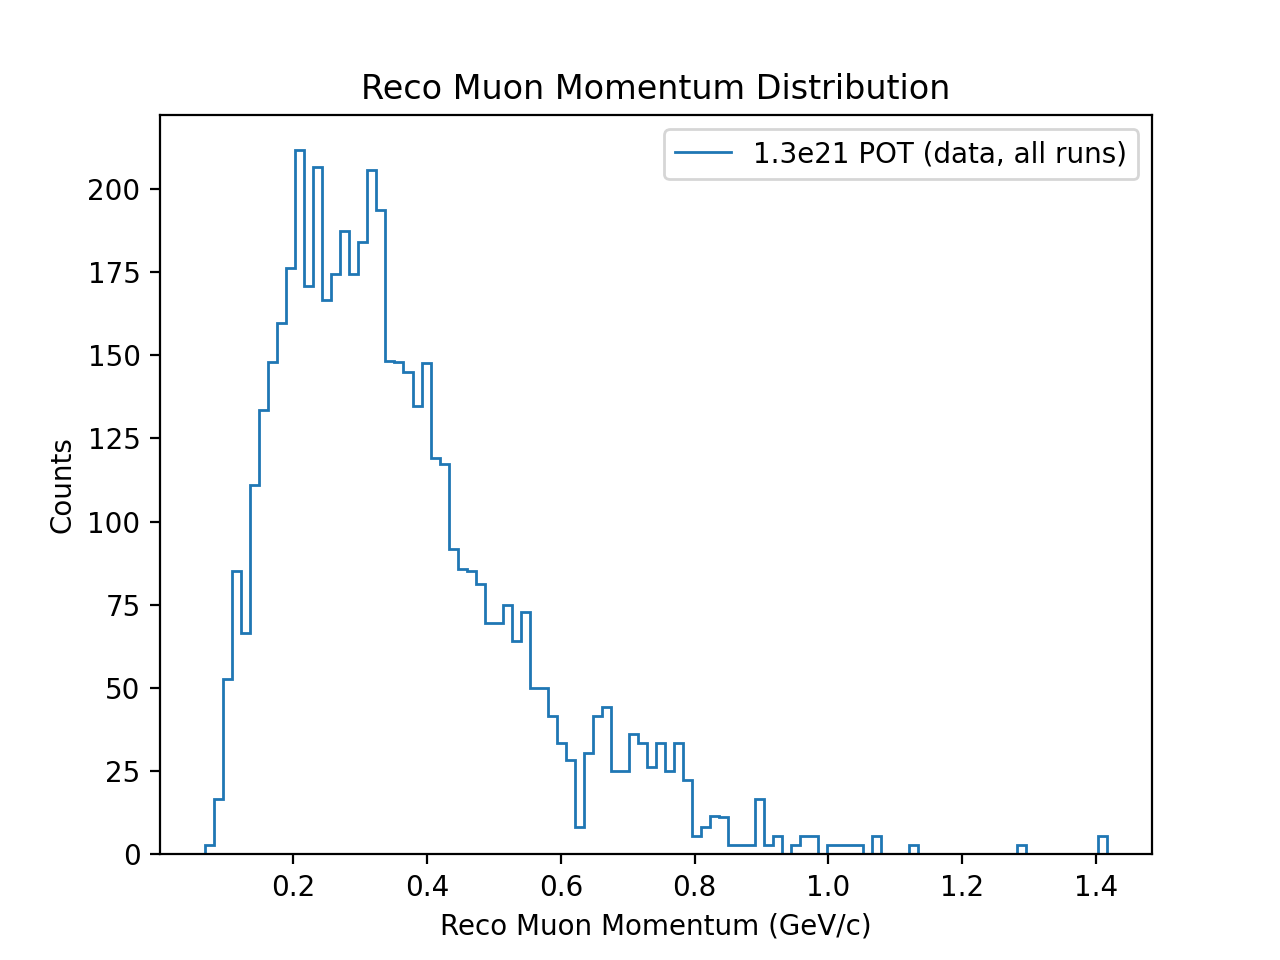

In [6]:
# reco muon mom

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(recoMuMom_arr, bins=100, weights=weights_arr)
scaledCounts = counts*scale


plt.stairs(scaledCounts, bins, label="1.3e21 POT (data, all runs)")
#plt.stairs(counts, bins, label="4.68e20 POT (sim, Run 1)")

plt.xlabel('Reco Muon Momentum (GeV/c)')
plt.ylabel('Counts')
plt.title('Reco Muon Momentum Distribution')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

<IPython.core.display.Javascript object>


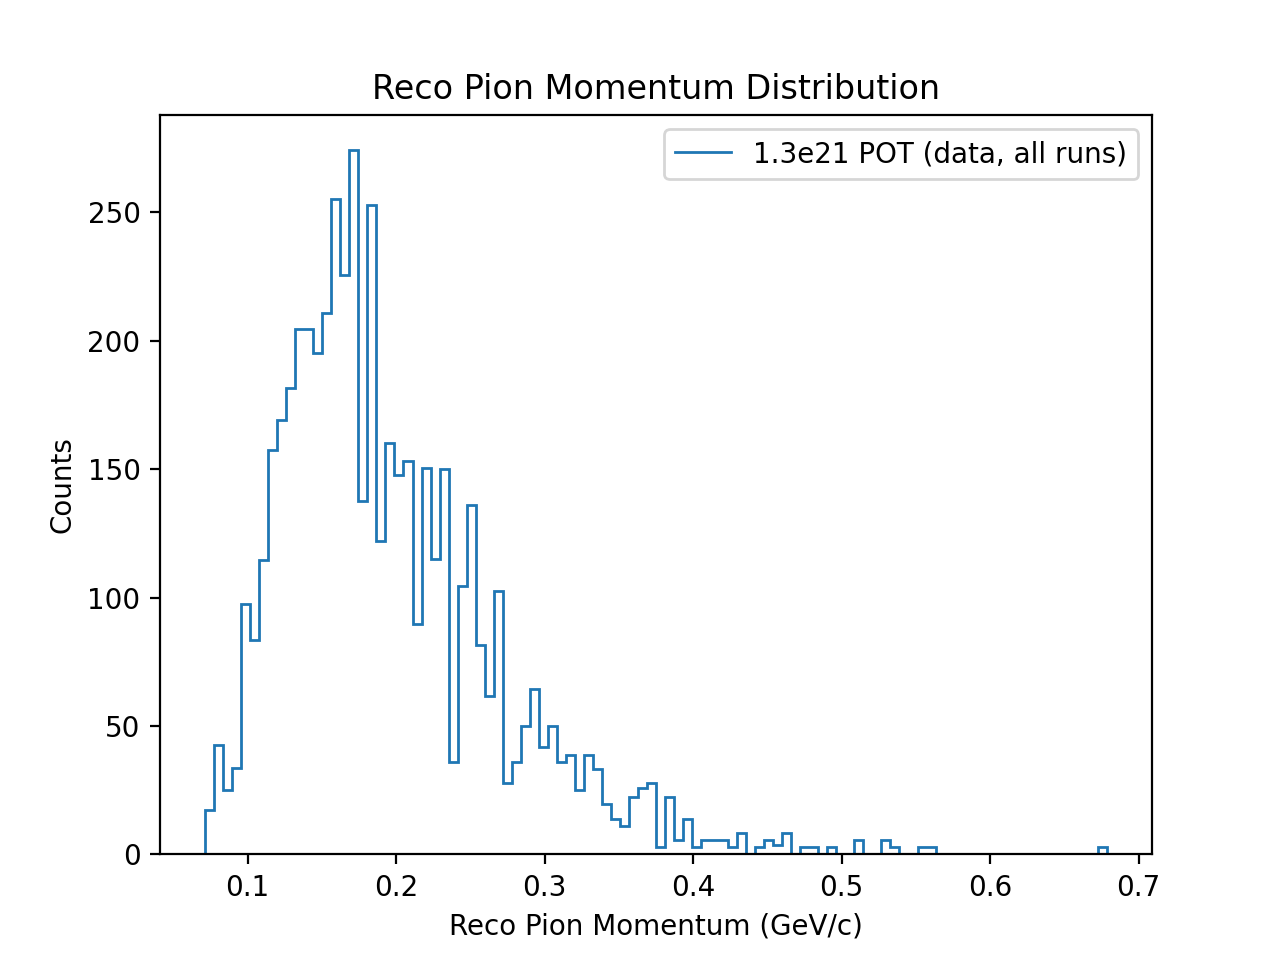

In [7]:
# reco pion mom

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(recoPiMom_arr, bins=100, weights=weights_arr)
scaledCounts = counts*scale


plt.stairs(scaledCounts, bins, label="1.3e21 POT (data, all runs)")
#plt.stairs(counts, bins, label="4.68e20 POT (sim, Run 1)")

plt.xlabel('Reco Pion Momentum (GeV/c)')
plt.ylabel('Counts')
plt.title('Reco Pion Momentum Distribution')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

<IPython.core.display.Javascript object>


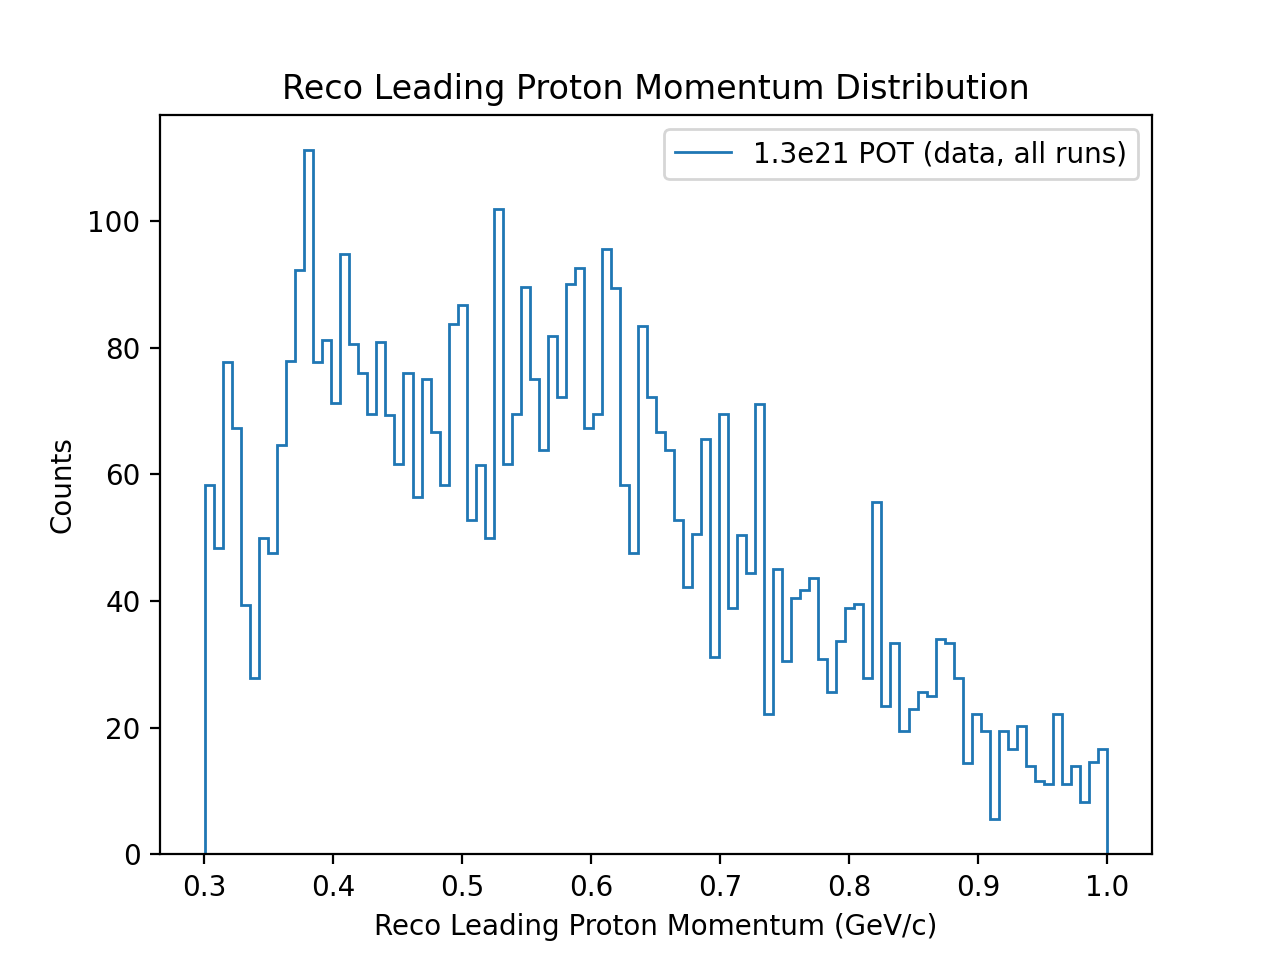

In [8]:
# reco leading proton mom

ax = plt.figure().gca()
ax.yaxis.get_major_locator().set_params(integer=True)

counts, bins = np.histogram(recoLPMom_arr, bins=100, weights=weights_arr)
scaledCounts = counts*scale


plt.stairs(scaledCounts, bins, label="1.3e21 POT (data, all runs)")
#plt.stairs(counts, bins, label="4.68e20 POT (sim, Run 1)")

plt.xlabel('Reco Leading Proton Momentum (GeV/c)')
plt.ylabel('Counts')
plt.title('Reco Leading Proton Momentum Distribution')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)